In [5]:
from mmdet3d.apis import init_model, inference_detector

config_file = 'mmdetection3d/configs/pointpillars/pointpillars_hv_secfpn_8xb6-160e_kitti-3d-car.py'
checkpoint_file = 'pre-trained/hv_pointpillars_secfpn_6x8_160e_kitti-3d-car_20220331_134606-d42d15ed.pth'
model = init_model(config_file, checkpoint_file, device='cpu')
inference_detector(model, 'mmdetection3d/demo/data/kitti/000008.bin')

Loads checkpoint by local backend from path: hv_pointpillars_secfpn_6x8_160e_kitti-3d-car_20220331_134606-d42d15ed.pth


(<Det3DDataSample(
 
     META INFORMATION
     lidar_path: 'mmdetection3d/demo/data/kitti/000008.bin'
     pcd_trans: array([0., 0., 0.])
     pcd_rotation_angle: 0.0
     axis_align_matrix: array([[1., 0., 0., 0.],
                [0., 1., 0., 0.],
                [0., 0., 1., 0.],
                [0., 0., 0., 1.]])
     pcd_horizontal_flip: False
     box_type_3d: <class 'mmdet3d.structures.bbox_3d.lidar_box3d.LiDARInstance3DBoxes'>
     pcd_vertical_flip: False
     box_mode_3d: <Box3DMode.LIDAR: 0>
     pcd_scale_factor: 1.0
     pcd_rotation: tensor([[1., 0., 0.],
                 [-0., 1., 0.],
                 [0., 0., 1.]])
     transformation_3d_flow: ['R', 'S', 'T']
     flip: False
 
     DATA FIELDS
     pred_instances_3d: <InstanceData(
         
             META INFORMATION
         
             DATA FIELDS
             bboxes_3d: LiDARInstance3DBoxes(
                     tensor([[ 14.7584,  -1.0538,  -1.5590,   3.7563,   1.6060,   1.5587,  -0.3131],
                 

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from bagpy import bagreader
from rosbags.image import message_to_cvimage
from collections import defaultdict
import cv2 as cv
import open3d as o3d
import detectron2
import sensor_msgs.point_cloud2 as pc2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import pyrealsense2 as rs2
if (not hasattr(rs2, 'intrinsics')):
    import pyrealsense2.pyrealsense2 as rs2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [18]:
path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.bag")
bag = bagreader(path).reader

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33 already exists. Not creating.


In [12]:
def msgs(bag):
    """For extracting msgs from Rosbag reader

    Returns:
        Dict[str, List]: list of messages and sequences of each kind
    """
    topic_list = [
        "/camera_left/color/image_raw",
        "/camera_left/aligned_depth_to_color/image_raw",
        "/camera_left/depth/color/points",
        "/camera_left/aligned_depth_to_color/camera_info",
        "/detected_persons/yolo",
        "/detected_persons_synchronized"
    ]
    image_msgs = []
    depth_msgs = []
    depth_pts_msgs = []
    pers_msgs = []
    ci_msgs = []
    sync_msgs = []

    counter1 = 100
    counter2 = 100
    counter3 = 100
    counter4 = 100
    counter5 = 100
    counter6 = 100

    for topic, msg, t in bag.read_messages(topics=topic_list):
        
        if counter1 > 0 or counter2 > 0 or counter3 > 0 or counter4 > 0 or counter5>0 and counter6>0:
            if topic == "/camera_left/color/image_raw":
                image_msgs.append(msg)
                counter1 -= 1

            if topic == "/camera_left/aligned_depth_to_color/image_raw":
                depth_msgs.append(msg)
                counter2 -= 1

            if topic == "/camera_left/depth/color/points":
                depth_pts_msgs.append(msg)
                counter3 -= 1

            if topic == "/camera_left/aligned_depth_to_color/camera_info":
                ci_msgs.append(msg)
                counter4 -= 1

            if topic =="/detected_persons/yolo":
                pers_msgs.append(msg)
                counter5 -=1

            if topic == "/detected_persons_synchronized":
                sync_msgs.append(msg)
                counter6 -= 1
        else:
                break


    bag.close()

    data_params = {
        "image_msgs": image_msgs,
        "depth_msgs": depth_msgs,
        "depth_pts_msgs": depth_pts_msgs,
        "pers_msgs": pers_msgs,
        "ci_msgs": ci_msgs,
        "sync_msgs": sync_msgs,
    }

    return data_params
data_params = msgs(bag)

In [16]:
tmp_msg = data_params["sync_msgs"][0]
print(tmp_msg)

header: 
  seq: 86
  stamp: 
    secs: 1616680353
    nsecs:  25540448
  frame_id: "tf_qolo_world"
detections: 
  - 
    detection_id: 642
    confidence: 0.9944700002670288
    pose: 
      pose: 
        position: 
          x: 10.636240182735504
          y: -1.9087339525255549
          z: 0.959884931181576
        orientation: 
          x: 0.0
          y: 0.0
          z: 0.0
          w: 1.0
      covariance: [0.05, 2.7031299443850025e-18, 7.528034336814145e-19, 0.0, 0.0, 0.0, 3.179648152285551e-18, 0.05000000000000001, -2.682883753346446e-18, 0.0, 0.0, 0.0, 6.851029504205345e-19, -2.335030174282334e-18, 0.049999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1000000.0]
    height: 1.85
    bbox_x: 440.0
    bbox_y: 203.0
    bbox_w: 34.0
    bbox_h: 90.0
    modality: "mono"
    embed_vector: []
    warp_loss: 0.0
  - 
    detection_id: 643
    confidence: 0.9929215312004089
    pose: 
      pose: 
 

In [17]:
tmp_msg = data_params["pers_msgs"][0]
print(tmp_msg)

header: 
  seq: 89
  stamp: 
    secs: 1616680352
    nsecs: 712948576
  frame_id: "camera_left_color_optical_frame"
detections: 
  - 
    detection_id: 658
    confidence: 0.990127444267273
    pose: 
      pose: 
        position: 
          x: -0.38936211035001733
          y: -0.027513600453769067
          z: 1.7850000000000001
        orientation: 
          x: 0.0
          y: 0.0
          z: 0.0
          w: 1.0
      covariance: [0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1000000.0]
    height: 1.85
    bbox_x: 60.0
    bbox_y: 10.0
    bbox_w: 248.0
    bbox_h: 457.0
    modality: "mono"
    embed_vector: []
    warp_loss: 0.0
  - 
    detection_id: 659
    confidence: 0.9831373691558838
    pose: 
      pose: 
        position: 
          x: 2.410667697874895
          y: 0.008024528985546318
          z: 10.468
        orientati

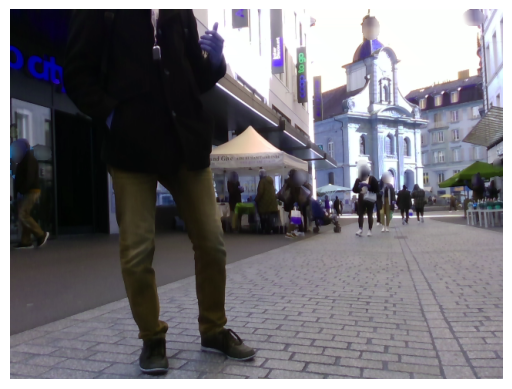

In [7]:
tmp_msg = data_params["image_msgs"][0]
img = message_to_cvimage(tmp_msg)
plt.axis('off')
plt.imshow(img)


header: 
  seq: 178
  stamp: 
    secs: 1616680362
    nsecs: 700109312
  frame_id: "camera_left_color_optical_frame"
height: 480
width: 640
encoding: "16UC1"
is_bigendian: 0
step: 1280
data: [131, 26, 131, 26, 27, 27, 27, 27, 106, 27, 106, 27, 184, 28, 184, 28, 17, 29, 17, 29, 201, 29, 201, 29, 138, 30, 138, 30, 190, 31, 190, 31, 190, 31, 190, 31, 43, 32, 43, 32, 190, 31, 190, 31, 190, 31, 190, 31, 85, 31, 85, 31, 138, 30, 138, 30, 201, 29, 201, 29, 201, 29, 201, 29, 108, 29, 108, 29, 184, 28, 184, 28, 98, 28, 98, 28, 13, 28, 13, 28, 106, 27, 106, 27, 27, 27, 27, 27, 131, 26, 131, 26, 57, 26, 57, 26, 57, 26, 57, 26, 57, 26, 57, 26, 241, 25, 241, 25, 241, 25, 241, 25, 170, 25, 170, 25, 170, 25, 170, 25, 170, 25, 170, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 26, 131, 26, 57, 26, 57, 26, 2

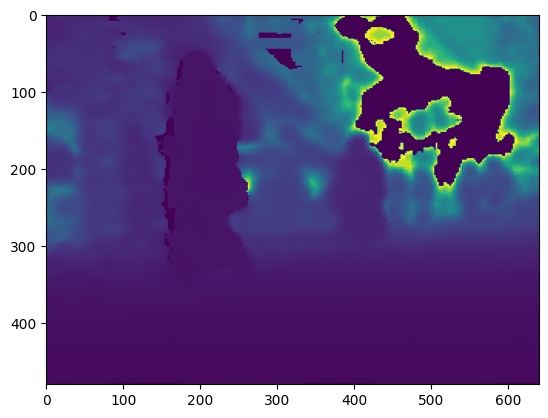

In [15]:
depth_msg = data_params["depth_msgs"][81]
print(depth_msg)
img2 = message_to_cvimage(depth_msg)
plt.imshow(img2)

# Synchronize msgs

In [2]:
import sys
import rosbag
import time
import subprocess
import yaml
import rospy
import os
import argparse
import math
from shutil import move

try:
    from yaml import CSafeLoader as Loader
except ImportError:
    from yaml import SafeLoader as Loader

In [3]:
path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.bag")
bag = bagreader(path).reader

ROSBagException: Bag contains no message

In [22]:
def status(length, percent):
  sys.stdout.write('\x1B[2K') # Erase entire current line
  sys.stdout.write('\x1B[0E') # Move to the beginning of the current line
  progress = "Progress: ["
  for i in range(0, length):
    if i < length * percent:
      progress += '='
    else:
      progress += ' '
  progress += "] " + str(round(percent * 100.0, 2)) + "%"
  sys.stdout.write(progress)
  sys.stdout.flush()

In [48]:
import matplotlib.patches as patches

In [24]:
bagfile = path
  
output = subprocess.Popen(['rosbag', 'info', '--yaml', bagfile], stdout=subprocess.PIPE).communicate()[0]
print(output)
info_dict = yaml.load(output, Loader)
duration = info_dict['duration']
start_time = info_dict['start']

orig = os.path.splitext(bagfile)[0] + ".orig.bag"

move(bagfile, orig)

with rosbag.Bag(bagfile, 'w') as outbag:
    
    last_time = time.process_time()
    for topic, msg, t in rosbag.Bag(orig).read_messages():
        
        if time.process_time() - last_time > .1:
            percent = (t.to_sec() - start_time) / duration
            status(40, percent)
            last_time = time.process_time()

b'path: /home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33.bag\nversion: 2.0\nduration: 130.335154\nstart: 1616680352.712949\nend: 1616680483.048103\nsize: 8507122081\nmessages: 293656\nindexed: True\ncompression: none\ntypes:\n    - type: darknet_ros_msgs/BoundingBoxes\n      md5: 004f6f4f48a741582d10735997905846\n    - type: diagnostic_msgs/DiagnosticArray\n      md5: 60810da900de1dd6ddd437c3503511da\n    - type: frame_msgs/DetectedPersons\n      md5: 029b53c4a16456adc9cba4f6be031872\n    - type: frame_msgs/TrackedPersons\n      md5: 8a65c8b517318ce06c4758db5831e100\n    - type: nav_msgs/Odometry\n      md5: cd5e73d190d741a2f92e81eda573aca7\n    - type: rds_network_ros/ToGui\n      md5: f4d51a23eb032fb6a05629b0c549bc90\n    - type: rwth_perception_people_msgs/GroundPlane\n      md5: 304eb2260bc88a91236784c7dd166ffd\n    - type: rwth_perception_people_msgs/PedestrianTrackingArray\n      md5: a9f67479ca0db5489cca876d9f98fd50

In [3]:
path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.orig.bag")
bag = bagreader(path).reader
def msgs(bag):
    """For extracting msgs from Rosbag reader

    Returns:
        Dict[str, List]: list of messages and sequences of each kind
    """
    topic_list = [
        "/camera_left/color/image_raw",
        "/camera_left/aligned_depth_to_color/image_raw",
        "/camera_left/depth/color/points",
        "/camera_left/aligned_depth_to_color/camera_info",
        "/detected_persons/yolo",
        "/detected_persons_synchronized"
    ]
    image_msgs = []
    depth_msgs = []
    depth_pts_msgs = []
    pers_msgs = []
    ci_msgs = []
    sync_msgs = []


    for topic, msg, t in bag.read_messages(topics=topic_list):
        
        if topic == "/camera_left/color/image_raw":
            image_msgs.append(msg)

        if topic =="/detected_persons/yolo":
            pers_msgs.append(msg)

        if topic == "/detected_persons_synchronized":
            sync_msgs.append(msg)


    bag.close()

    data_params = {
        "image_msgs": image_msgs,
        "pers_msgs": pers_msgs,
        "sync_msgs": sync_msgs,
    }

    return data_params
data_params = msgs(bag)

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33.orig already exists. Not creating.


In [4]:
data1 = {}
timestamps = []
detections = []
for i in data_params["pers_msgs"]:
    timestamps.append(i.header.stamp.to_time())
    detection = []
    # reduce information about each detection to the necessary things
    for j in i.detections:
        # save from detections: confidence score, positionx, positiony, positionz, bboxx, bboxy, bboxw, bboxh
        conf_score = j.confidence
        pos = [j.pose.pose.position.x, j.pose.pose.position.y, j.pose.pose.position.z]
        bbox = [j.bbox_x, j.bbox_y, j.bbox_w, j.bbox_h]
        detection.append([conf_score, pos, bbox])
    detections.append(detection)
data1 = {"timestamps": np.array(timestamps), "detections": detections}

In [5]:
data2 = {}
timestamps = []
img_msgs = []
for i in data_params["image_msgs"]:
    timestamps.append(i.header.stamp.to_time())
    img_msgs.append(i)
data2 = {"timestamps": np.array(timestamps), "img_msgs": img_msgs}

In [90]:
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
df_pers = pd.DataFrame.from_dict(data=data1)
df_img = pd.DataFrame.from_dict(data=data2)

In [102]:
df_pers.sort_values(by="timestamps",inplace=True)
df_img.sort_values(by="timestamps",inplace=True)

In [106]:
merged_df = pd.merge_asof(df_pers, df_img, on="timestamps", direction="nearest")
merged_df

,timestamps,detections,img_msgs
0,1616680352.71,"[[0.990127444267273, [-0.38936211035001733, -0...",header: \n seq: 178\n stamp: \n secs: 161...
1,1616680352.83,"[[0.9889856576919556, [2.434882329030057, 0.00...",header: \n seq: 180\n stamp: \n secs: 161...
2,1616680352.90,"[[0.993348240852356, [-0.40092064309254183, -0...",header: \n seq: 181\n stamp: \n secs: 161...
3,1616680353.03,"[[0.9944700002670288, [2.383170036323165, 0.00...",header: \n seq: 182\n stamp: \n secs: 161...
4,1616680353.13,"[[0.9944361448287964, [-0.3997900988003534, -0...",header: \n seq: 183\n stamp: \n secs: 161...
...,...,...,...
1041,1616680482.27,"[[0.9972365498542786, [-3.2723291423496175, -0...",header: \n seq: 2030\n stamp: \n secs: 16...
1042,1616680482.28,"[[0.9976322650909424, [-2.485738105996217, -0....",header: \n seq: 2032\n stamp: \n secs: 16...
1043,1616680482.52,"[[0.9987186193466187, [3.7260399079066175, -0....",header: \n seq: 2033\n stamp: \n secs: 16...
1044,1616680482.62,"[[0.9985901713371277, [3.078814208471769, -0.6...",header: \n seq: 2034\n stamp: \n secs: 16...


In [104]:
tmp_msg = data_params["pers_msgs"][70]
img_msg = data_params["image_msgs"][100]

In [122]:
# load data from merged dataframe
idx = 450
detected_idx = 0
img_msg = merged_df.iloc[idx].img_msgs
x, y, w, h = merged_df.iloc[idx].detections[detected_idx][2]

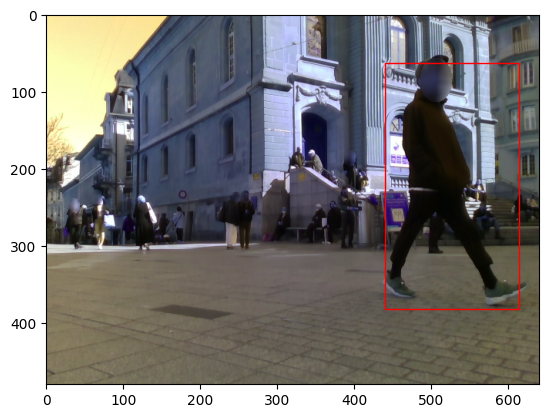

In [123]:
from matplotlib import patches
img = message_to_cvimage(img_msg)

plt.Rectangle((x, y), w, h)

fig, ax = plt.subplots()
ax.imshow(img)
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


# Get tracked pedestrians with unique ids

In [3]:
path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.orig.bag")
bag = bagreader(path).reader
def msgs(bag, topic_):
    """For extracting msgs from Rosbag reader

    Returns:
        Dict[str, List]: list of messages and sequences of each kind
    """
    topic_list = [
        topic_
    ]
    msgs = []

    for topic, msg, t in bag.read_messages(topics=topic_list):
        
        if topic == topic_:
            msgs.append(msg)

    bag.close()


    return msgs
topic_msgs = msgs(bag, "/rwth_tracker/tracked_persons")

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33.orig already exists. Not creating.


In [140]:
topic_msgs[100].tracks[0]

track_id: 2
is_occluded: False
is_matched: True
detection_id: 2514
age: 
  secs: 12
  nsecs:  51514176
height: 1.85
pose: 
  pose: 
    position: 
      x: 0.0715746784228208
      y: -1.3375972335375825
      z: 0.0
    orientation: 
      x: 0.0
      y: 0.0
      z: -0.11233893481968754
      w: 0.9936699470767837
  covariance: [0.017331123516084845, -7.004610206713748e-19, 0.0, 0.0, 0.0, 0.0, 5.957033424760908e-19, 0.017331123516084842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9999999.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9999999.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9999999.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.030461741978670857]
twist: 
  twist: 
    linear: 
      x: 0.027675436037137992
      y: -0.006338686275360802
      z: 0.0
    angular: 
      x: 0.0
      y: 0.0
      z: 0.0
  covariance: [0.06688641686320748, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06688641686320748, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9999999.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9999999.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9999999.0, 0.0, 0.0, 0.

In [13]:
merged_df

,timestamps,detections,img_msgs,vox_msgs
0,1616680352.71,"[[0.990127444267273, [-0.38936211035001733, -0...",header: \n seq: 178\n stamp: \n secs: 161...,VoxelGrid with 675 voxels.
1,1616680352.83,"[[0.9889856576919556, [2.434882329030057, 0.00...",header: \n seq: 180\n stamp: \n secs: 161...,VoxelGrid with 665 voxels.
2,1616680352.90,"[[0.993348240852356, [-0.40092064309254183, -0...",header: \n seq: 181\n stamp: \n secs: 161...,VoxelGrid with 667 voxels.
3,1616680353.03,"[[0.9944700002670288, [2.383170036323165, 0.00...",header: \n seq: 182\n stamp: \n secs: 161...,VoxelGrid with 658 voxels.
4,1616680353.13,"[[0.9944361448287964, [-0.3997900988003534, -0...",header: \n seq: 183\n stamp: \n secs: 161...,VoxelGrid with 686 voxels.
...,...,...,...,...
1041,1616680482.27,"[[0.9972365498542786, [-3.2723291423496175, -0...",header: \n seq: 2030\n stamp: \n secs: 16...,VoxelGrid with 621 voxels.
1042,1616680482.28,"[[0.9976322650909424, [-2.485738105996217, -0....",header: \n seq: 2032\n stamp: \n secs: 16...,VoxelGrid with 621 voxels.
1043,1616680482.52,"[[0.9987186193466187, [3.7260399079066175, -0....",header: \n seq: 2033\n stamp: \n secs: 16...,VoxelGrid with 621 voxels.
1044,1616680482.62,"[[0.9985901713371277, [3.078814208471769, -0.6...",header: \n seq: 2034\n stamp: \n secs: 16...,VoxelGrid with 621 voxels.


In [23]:
imgs = merged_df.iloc[:30].img_msgs
dets = merged_df.iloc[:30].detections

In [33]:
# TODO: transform bbox to [xmin, ymin, xmax, ymax] for motpy
def yolobbox2bbox(input):
    x,y,w,h = input
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    return np.asarray([x1, y1, x2, y2])

In [35]:
import numpy as np
from random import randint
from motpy import Detection, MultiObjectTracker

tracker = MultiObjectTracker(dt=0.1)

colors = []

# Initialize MultiTracker
for det in dets[0]:
  colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))

for im_ms, det_ms in zip(imgs, dets):
  img = message_to_cvimage(im_ms).copy()
  bbox_s = []
  for d in det_ms:
    bbox_s.append(yolobbox2bbox(d[2]))
  print(bbox_s)
  tracker.step(detections=[Detection(box=bbox_s)])

  tracks = tracker.active_tracks()

  print('MOT tracker tracks %d objects' % len(tracks))
  print('first track box: %s' % str(tracks[0].box))

  

[array([ -64. , -218.5,  184. ,  238.5]), array([429. , 157.5, 461. , 248.5]), array([493.5, 195. , 512.5, 253. ]), array([295., 168., 331., 250.]), array([469.5, 169.5, 488.5, 248.5]), array([269. , 169.5, 291. , 246.5]), array([-21.5,  92.5,  21.5, 241.5]), array([511.5, 201.5, 530.5, 252.5])]


AssertionError: 

In [28]:
import cv2 as cv
from random import randint
multiTracker = cv.legacy.MultiTracker_create()

colors = []

# Initialize MultiTracker
for det in dets[0]:
  colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))
  bbox = det[2]
  img = message_to_cvimage(imgs[0])
  multiTracker.add(cv.legacy.TrackerBoosting_create(), img, bbox)

for im_ms, det_ms in zip(imgs[1:], dets[1:]):
  img = message_to_cvimage(im_ms).copy()
  bbox_s = []
  for d in det_ms:
    bbox_s.append(d[2])
  success, boxes = multiTracker.update(img,bbox_s)

  # draw tracked objects
  for i, newbox in enumerate(boxes):
    p1 = (int(newbox[0]), int(newbox[1]))
    p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
    cv.rectangle(img, p1, p2, colors[i], 2, 1)
 
  # show frame
  cv.imshow('MultiTracker', img)
  cv.waitKey(1)
cv.destroyAllWindows()

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'update'
> Overload resolution failed:
>  - legacy_MultiTracker.update() takes at most 1 argument (2 given)
>  - legacy_MultiTracker.update() takes at most 1 argument (2 given)


In [40]:
from deepsort.tracker import DeepSortTracker
from deepsort.detection import Detection


tracker = DeepSortTracker()
for detection in dets:
   #transform every single detection in a Detection format
   ds = []
   for d in detection:
      # tlwh = (x,y,w,h), feature = position
      tmp = Detection(tlwh=d[2], confidence=d[0], feature=d[1])
      ds.append(tmp)


   online_targets = tracker.update(ds)

TypeError: tuple indices must be integers or slices, not tuple

# Get scene context

In [6]:
path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.orig.bag")
bag = bagreader(path).reader
def msgs(bag, topic_):
    """For extracting msgs from Rosbag reader

    Returns:
        Dict[str, List]: list of messages and sequences of each kind
    """
    topic_list = [
        topic_
    ]
    msgs = []

    for topic, msg, t in bag.read_messages(topics=topic_list):
        
        if topic == topic_:
            msgs.append(msg)

    bag.close()


    return msgs
topic_msgs = msgs(bag, "/front_lidar/velodyne_points")
#topic_msgs = msgs(bag, "/front_lidar/scan")

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33.orig already exists. Not creating.


In [5]:
tmp_msg = topic_msgs[0]

In [7]:
# voxelgrid from pointcloud
import open3d as o3d
def pc_to_grid(tmp_msg):
    points_obj = pc2.read_points(tmp_msg, skip_nans=True, field_names=("x", "y", "z"))
    pc = np.array(list(points_obj), dtype=np.float32)
    pc[:,2] = 0
    #print(pc.shape)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pc)
    #print(len(pcd.points))

    # fit to unit cube
    pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
            center=pcd.get_center())
    #o3d.visualization.draw_geometries([pcd])
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                                voxel_size=0.01)
    #o3d.visualization.draw_geometries([voxel_grid])
    return voxel_grid

In [8]:
# create dataframe with voxels
timestamps = []
voxel_msgs = []
for i in topic_msgs:
    timestamps.append(i.header.stamp.to_time())
    vox = pc_to_grid(i)
    voxel_msgs.append(vox)
data3 = {"timestamps": np.array(timestamps), "vox_msgs": voxel_msgs}

In [9]:
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
df_pers = pd.DataFrame.from_dict(data=data1)
df_img = pd.DataFrame.from_dict(data=data2)
df_vox = pd.DataFrame.from_dict(data=data3)

In [10]:
df_pers.sort_values(by="timestamps",inplace=True)
df_img.sort_values(by="timestamps",inplace=True)
df_vox.sort_values(by="timestamps", inplace=True)

In [11]:
merged_df = pd.merge_asof(df_pers, df_img, on="timestamps", direction="nearest")
merged_df

,timestamps,detections,img_msgs
0,1616680352.71,"[[0.990127444267273, [-0.38936211035001733, -0...",header: \n seq: 178\n stamp: \n secs: 161...
1,1616680352.83,"[[0.9889856576919556, [2.434882329030057, 0.00...",header: \n seq: 180\n stamp: \n secs: 161...
2,1616680352.90,"[[0.993348240852356, [-0.40092064309254183, -0...",header: \n seq: 181\n stamp: \n secs: 161...
3,1616680353.03,"[[0.9944700002670288, [2.383170036323165, 0.00...",header: \n seq: 182\n stamp: \n secs: 161...
4,1616680353.13,"[[0.9944361448287964, [-0.3997900988003534, -0...",header: \n seq: 183\n stamp: \n secs: 161...
...,...,...,...
1041,1616680482.27,"[[0.9972365498542786, [-3.2723291423496175, -0...",header: \n seq: 2030\n stamp: \n secs: 16...
1042,1616680482.28,"[[0.9976322650909424, [-2.485738105996217, -0....",header: \n seq: 2032\n stamp: \n secs: 16...
1043,1616680482.52,"[[0.9987186193466187, [3.7260399079066175, -0....",header: \n seq: 2033\n stamp: \n secs: 16...
1044,1616680482.62,"[[0.9985901713371277, [3.078814208471769, -0.6...",header: \n seq: 2034\n stamp: \n secs: 16...


In [12]:
merged_df = pd.merge_asof(merged_df, df_vox, on="timestamps", direction="nearest")
merged_df

,timestamps,detections,img_msgs,vox_msgs
0,1616680352.71,"[[0.990127444267273, [-0.38936211035001733, -0...",header: \n seq: 178\n stamp: \n secs: 161...,VoxelGrid with 675 voxels.
1,1616680352.83,"[[0.9889856576919556, [2.434882329030057, 0.00...",header: \n seq: 180\n stamp: \n secs: 161...,VoxelGrid with 665 voxels.
2,1616680352.90,"[[0.993348240852356, [-0.40092064309254183, -0...",header: \n seq: 181\n stamp: \n secs: 161...,VoxelGrid with 667 voxels.
3,1616680353.03,"[[0.9944700002670288, [2.383170036323165, 0.00...",header: \n seq: 182\n stamp: \n secs: 161...,VoxelGrid with 658 voxels.
4,1616680353.13,"[[0.9944361448287964, [-0.3997900988003534, -0...",header: \n seq: 183\n stamp: \n secs: 161...,VoxelGrid with 686 voxels.
...,...,...,...,...
1041,1616680482.27,"[[0.9972365498542786, [-3.2723291423496175, -0...",header: \n seq: 2030\n stamp: \n secs: 16...,VoxelGrid with 621 voxels.
1042,1616680482.28,"[[0.9976322650909424, [-2.485738105996217, -0....",header: \n seq: 2032\n stamp: \n secs: 16...,VoxelGrid with 621 voxels.
1043,1616680482.52,"[[0.9987186193466187, [3.7260399079066175, -0....",header: \n seq: 2033\n stamp: \n secs: 16...,VoxelGrid with 621 voxels.
1044,1616680482.62,"[[0.9985901713371277, [3.078814208471769, -0.6...",header: \n seq: 2034\n stamp: \n secs: 16...,VoxelGrid with 621 voxels.
